# Naive

$$
\mathcal{L} = 
$$

In [1]:
%load_ext autoreload
%autoreload 2

# Libraries

In [2]:
import pickle
from tqdm import tqdm

In [3]:
from avalanche.benchmarks.classic import PermutedMNIST
from avalanche.models import SimpleMLP
from avalanche.training import Naive
from avalanche.training.plugins import EvaluationPlugin
from avalanche.logging import InteractiveLogger
from avalanche.evaluation.metrics import (
    accuracy_metrics,
    bwt_metrics,
    confusion_matrix_metrics,
    forgetting_metrics,
    timing_metrics,
    cpu_usage_metrics,
    gpu_usage_metrics,
    disk_usage_metrics,
    ram_usage_metrics,
    loss_metrics,
    class_accuracy_metrics,
    accuracy_matrix_metrics
)

from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torch import cuda

/Users/jesusoyanedelespinoza/.pyenv/versions/3.9.18/envs/tt2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Custom Libraries

In [4]:
import sys

sys.path.append("../base_code/")

from base_code.constants import DATASETS_PATH, SAVED_METRICS_PATH
from base_code.plugins import WeightStoragePlugin

# Constants

In [5]:
TORCH_DEVICE = "cuda" if cuda.is_available() else "cpu"
N_EXPERIENCES = 5
EXPERIMENT_SEED = 1234
METRICS_SUBFOLDER = f"class_saturation/{N_EXPERIENCES}"
METRICS_FILENAME = f"{METRICS_SUBFOLDER}/naive.pkl"

# Dataset and definitions

## Dataset loading

We load state-of-the-art dataset Modified NIST

In [6]:
scenario = PermutedMNIST(N_EXPERIENCES, seed=EXPERIMENT_SEED, dataset_root=DATASETS_PATH)

## Scenario creation with train test streaming

In this point, we define our scenario considering a training where in every experience of it, a new class is presented. This is, first we train with a class $a$, the following experience we train with class $b$ ($a \neq b$)

In [7]:
train_stream = scenario.train_stream
test_stream = scenario.test_stream

## Evaluation metrics definition

In [8]:
eval_plugin = EvaluationPlugin(
    accuracy_metrics(experience=True, stream=True),
    loss_metrics(minibatch=True, experience=True, stream=True),
    timing_metrics(epoch=True, epoch_running=True),
    cpu_usage_metrics(minibatch=True, experience=True, stream=True),
    gpu_usage_metrics(experience=True, stream=True, gpu_id=TORCH_DEVICE),
    disk_usage_metrics(experience=True, stream=True),
    ram_usage_metrics(experience=True, stream=True),
    class_accuracy_metrics(experience=True, stream=True),
    accuracy_matrix_metrics(),
    forgetting_metrics(experience=True, stream=True),
    bwt_metrics(experience=True, stream=True),
    confusion_matrix_metrics(stream=True, num_classes=scenario.n_classes),
    
    loggers=[InteractiveLogger()]
)

/Users/jesusoyanedelespinoza/.pyenv/versions/3.9.18/envs/tt2/lib/python3.9/site-packages/avalanche/evaluation/metrics/gpu_usage.py:56: UserWarning: Your system has no GPU!
  warnings.warn("Your system has no GPU!")
/Users/jesusoyanedelespinoza/.pyenv/versions/3.9.18/envs/tt2/lib/python3.9/site-packages/avalanche/evaluation/metrics/gpu_usage.py:56: UserWarning: Your system has no GPU!
  warnings.warn("Your system has no GPU!")


## Plugin defitinitions

In [9]:
model_plugins = [WeightStoragePlugin()]

## Model, Optimizer, Loss function and Strategy definition

* `model`: Multi Layer Perceptron
* `Optimizer`: Adam
* `Loss function`: Cross Entropy
* `Strategy`: Elastic Weight Consolidation

In [10]:
model = SimpleMLP(num_classes=scenario.n_classes, input_size=28 * 28, hidden_layers=2, hidden_size=100).to(TORCH_DEVICE)
optimizer = SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0005)
criterion = CrossEntropyLoss().to(TORCH_DEVICE)
strategy = Naive(
    model,
    optimizer,
    criterion,
    train_epochs=5,
    train_mb_size=128,
    plugins=model_plugins,
    evaluator=eval_plugin,
    eval_mb_size=128,
    device=TORCH_DEVICE,
)

# Training and evaluation

Revisar porque el entrenamiento se está comportando de forma rara

  0%|          | 0/5 [00:00<?, ?it/s]

-- >> Start of training phase << --
100%|██████████| 469/469 [00:03<00:00, 127.33it/s]
Epoch 0 ended.
	CPUUsage_MB/train_phase/train_stream/Task000 = 111.1000
	Loss_MB/train_phase/train_stream/Task000 = 0.9134
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0001
	Time_Epoch/train_phase/train_stream/Task000 = 3.6840
100%|██████████| 469/469 [00:03<00:00, 129.24it/s]
Epoch 1 ended.
	CPUUsage_MB/train_phase/train_stream/Task000 = 116.6000
	Loss_MB/train_phase/train_stream/Task000 = 0.8847
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0000
	Time_Epoch/train_phase/train_stream/Task000 = 3.6289
100%|██████████| 469/469 [00:03<00:00, 129.40it/s]
Epoch 2 ended.
	CPUUsage_MB/train_phase/train_stream/Task000 = 114.8000
	Loss_MB/train_phase/train_stream/Task000 = 0.5903
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0000
	Time_Epoch/train_phase/train_stream/Task000 = 3.6246
100%|██████████| 469/469 [00:03<00:00, 129.38it/s]
Epoch 3 ended.
	CPUUsage_MB/train_phase/train_

 20%|██        | 1/5 [00:22<01:29, 22.34s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.3645
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x1643dac70>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 1790.3662
	EvalStream/Acc_Matrix = 
tensor([[0.9142, 0.0929, 0.1213, 0.1525, 0.1312],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])
	Loss_Stream/eval_phase/test_stream/Task000 = 2.3157
	MaxGPUcpuUsage_Stream/eval_phase/test_stream/Task000 = 0
	MaxRAMUsage_Stream/eval_phase/test_stream/Task000 = 394.0938
	StreamBWT/eval_phase/test_stream = 0.0000
	StreamForgetting/eval_phase/test_stream = 0.0000
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.2824
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/0 = 0.2094
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/1 = 0.

 40%|████      | 2/5 [00:44<01:07, 22.41s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.8875
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x167135a90>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 1790.3662
	EvalStream/Acc_Matrix = 
tensor([[0.9142, 0.0929, 0.1213, 0.1525, 0.1312],
        [0.8937, 0.9278, 0.1354, 0.1250, 0.1366],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])
	Loss_Stream/eval_phase/test_stream/Task000 = 1.8364
	MaxGPUcpuUsage_Stream/eval_phase/test_stream/Task000 = 0
	MaxRAMUsage_Stream/eval_phase/test_stream/Task000 = 363.6406
	StreamBWT/eval_phase/test_stream = -0.0205
	StreamForgetting/eval_phase/test_stream = 0.0205
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.4437
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/0 = 0.4041
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/1 = 0

 60%|██████    | 3/5 [01:09<00:46, 23.44s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 104.2255
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x16730da00>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 1790.3662
	EvalStream/Acc_Matrix = 
tensor([[0.9142, 0.0929, 0.1213, 0.1525, 0.1312],
        [0.8937, 0.9278, 0.1354, 0.1250, 0.1366],
        [0.8719, 0.9037, 0.9337, 0.0981, 0.1048],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])
	Loss_Stream/eval_phase/test_stream/Task000 = 1.5363
	MaxGPUcpuUsage_Stream/eval_phase/test_stream/Task000 = 0
	MaxRAMUsage_Stream/eval_phase/test_stream/Task000 = 242.8281
	StreamBWT/eval_phase/test_stream = -0.0332
	StreamForgetting/eval_phase/test_stream = 0.0332
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.5824
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/0 = 0.5949
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/1 = 0

 80%|████████  | 4/5 [01:34<00:23, 23.97s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 104.6044
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x1674028b0>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 1790.3662
	EvalStream/Acc_Matrix = 
tensor([[0.9142, 0.0929, 0.1213, 0.1525, 0.1312],
        [0.8937, 0.9278, 0.1354, 0.1250, 0.1366],
        [0.8719, 0.9037, 0.9337, 0.0981, 0.1048],
        [0.8258, 0.8707, 0.9165, 0.9356, 0.0813],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])
	Loss_Stream/eval_phase/test_stream/Task000 = 0.9393
	MaxGPUcpuUsage_Stream/eval_phase/test_stream/Task000 = 0
	MaxRAMUsage_Stream/eval_phase/test_stream/Task000 = 221.0000
	StreamBWT/eval_phase/test_stream = -0.0542
	StreamForgetting/eval_phase/test_stream = 0.0542
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.7260
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/0 = 0.7780
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/1 = 0

100%|██████████| 5/5 [01:57<00:00, 23.53s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 104.4851
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x1675e61f0>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 1790.3662
	EvalStream/Acc_Matrix = 
tensor([[0.9142, 0.0929, 0.1213, 0.1525, 0.1312],
        [0.8937, 0.9278, 0.1354, 0.1250, 0.1366],
        [0.8719, 0.9037, 0.9337, 0.0981, 0.1048],
        [0.8258, 0.8707, 0.9165, 0.9356, 0.0813],
        [0.7939, 0.8396, 0.8988, 0.9103, 0.9373]])
	Loss_Stream/eval_phase/test_stream/Task000 = 0.3926
	MaxGPUcpuUsage_Stream/eval_phase/test_stream/Task000 = 0
	MaxRAMUsage_Stream/eval_phase/test_stream/Task000 = 212.6250
	StreamBWT/eval_phase/test_stream = -0.0672
	StreamForgetting/eval_phase/test_stream = 0.0672
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.8760
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/0 = 0.9496
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/1 = 0

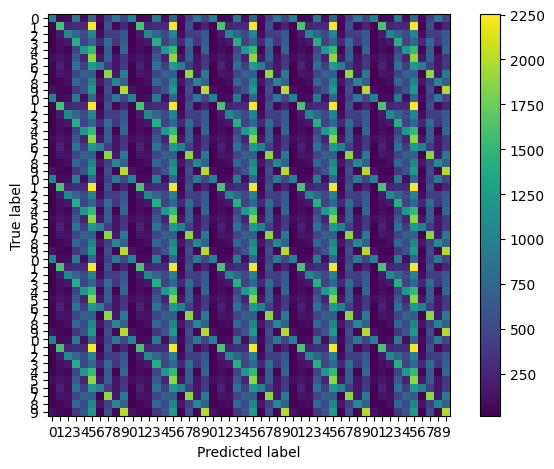

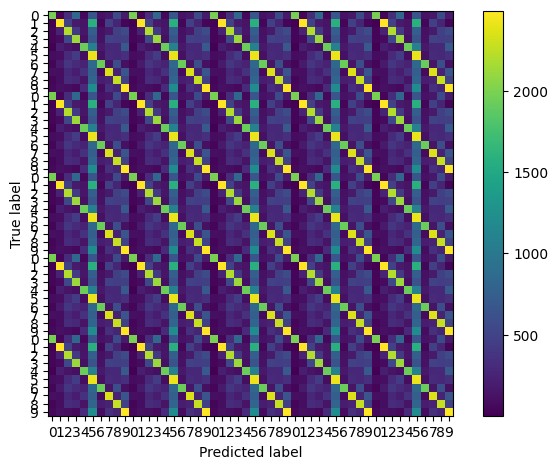

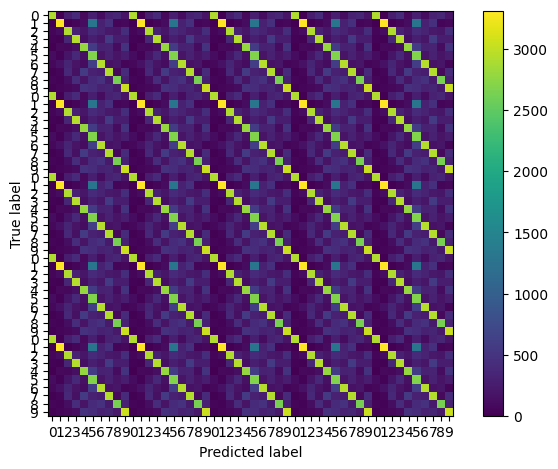

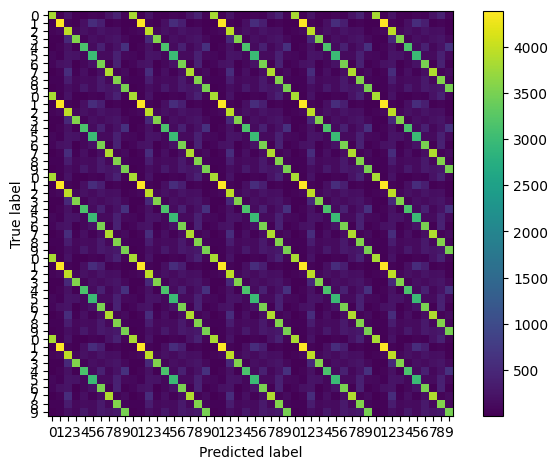

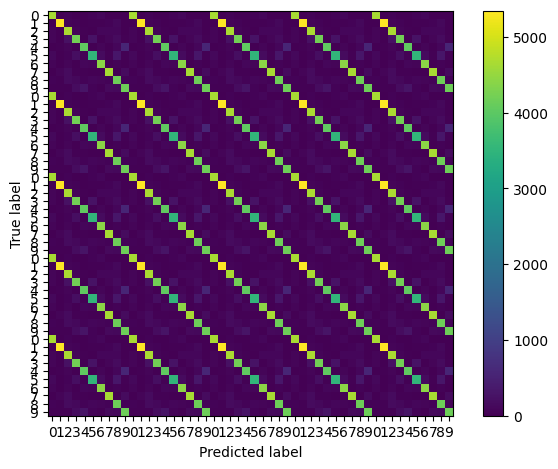

In [11]:
for experience in tqdm(train_stream):
    strategy.train(experience)
    strategy.eval(test_stream)

# Get metrics

In [12]:
accuracies: dict[int, list[float]] = dict()
forgettings: dict[int, list[float]] = dict()
bwt: dict[int, list[float]] = dict()
class_accuracies: dict[int, list[float]] = dict()
losses: dict[int, list[float]] = dict()

for i in range(N_EXPERIENCES):
    filled_i = str(i).zfill(3)
    accuracies[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp{filled_i}"
    ][1]
    forgettings[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"ExperienceForgetting/eval_phase/test_stream/Task000/Exp{filled_i}"
    ][1]
    bwt[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"ExperienceBWT/eval_phase/test_stream/Task000/Exp{filled_i}"
    ][1]
    class_accuracies[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/{i}"
    ][1]
    losses[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"Loss_Exp/eval_phase/test_stream/Task000/Exp{filled_i}"
    ][1]
        

accuracies["Overall"] = eval_plugin.get_all_metrics()[
    "Top1_Acc_Stream/eval_phase/test_stream/Task000"
][1]

In [13]:
train_cpu_usage = eval_plugin.get_all_metrics()["CPUUsage_MB/train_phase/train_stream/Task000"][1]
train_time_epoch = eval_plugin.get_all_metrics()["Time_Epoch/train_phase/train_stream/Task000"][1]
train_running_time = eval_plugin.get_all_metrics()["RunningTime_Epoch/train_phase/train_stream/Task000"][1]
train_loss_epoch = eval_plugin.get_all_metrics()["Loss_MB/train_phase/train_stream/Task000"][1]

In [14]:
weights = model_plugins[0].weights

# Store metrics

In [15]:
pickle.dump({
    "accuracies": accuracies,
    "forgettings": forgettings,
    "bwt": bwt,
    "class_accuracies": class_accuracies,
    "losses": losses,
    "train_cpu_usage": train_cpu_usage,
    "train_time_epoch": train_time_epoch,
    "train_running_time": train_running_time,
    "train_loss_epoch": train_loss_epoch,
    "weights": weights
}, open(SAVED_METRICS_PATH / METRICS_FILENAME, "wb"))